# Function for GPR Plot
## Example Parameter: Avg Leaf Nitrogen Concentration (LNC) vs Leaf Carbon Nitrogen Ratio (LCN)
#### Author: Sofia Ingersoll

In [1]:
# moved the libraries that were here into ml_utils.py because they're essential
# xarray is required to run the utils import line
import xarray as xr

from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, WhiteKernel
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error

In [2]:
# import libraries & data pre-processing functions from utils.py
from ml_utils import *

In [3]:
# Request an additional 10 cores of power for processing from the server
client = get_cluster("UCSB0021", cores = 40)

/glade/u/home/singersoll/.conda/envs/meds-py/lib/python3.11/site-packages/distributed/node.py:182: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 33741 instead
  warnings.warn(


In [4]:
# apply peer2peer network communication across multiple devices
client.cluster

PBSCluster(c2f2be7b, 'tcp://128.117.208.103:34925', workers=40, threads=40, memory=372.40 GiB)

Prepare the data for GPR, including selecting the target variable and the parameters as features.

Split the data into training and testing sets.

Define a grid of hyperparameters for the GPR model.

Perform grid search cross-validation to find the best hyperparameters.

Fit the GPR model using the best hyperparameters on the training data.

Generate predictions and confidence intervals for each variable using the trained model.

Plot the results, including the observed data, predicted values, and confidence intervals.

### 1st Attempt

In [5]:
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
# ----     load data stored in casper     ----
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
#------- Parameter Data---------
# x variable data for plotting
df = pd.read_csv('/glade/campaign/asp/djk2120/PPEn11/csvs/lhc220926.txt',index_col=0)
# the only dimension here is the 'member' aka file index id [LCH0001-500]
# convert to data set
params = xr.Dataset(df)
# subset in parameter file
leafcn = params['leafcn']

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
# ----    variable wrangling     ----
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
# apply the bug fixing & dim. reduction functions 
# read in variable cluster
da = read_all_simulations('LNC')

# feb. ncar time bug
da = fix_time(da)

# convert xr.ds to xr.da
da = da['LNC']

# weight gridcell dim by global land area
da_global = weight_landarea_gridcells(da,landarea)

# weight time dim by days in month
da_global_ann = yearly_weighted_average(da_global)

# take global avg for param over year dimension
lnc = da_global_ann.mean(dim='year')

In [6]:
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
# ----      Split Data 90/10        ----
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
x_train, x_test, y_train, y_test = train_test_split(leafcn.values.reshape(-1, 1), lnc.values.reshape(-1, 1), test_size=0.1, random_state=0)

In [7]:
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
# ----      Set up Tune Grid       ----
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
# Define a grid of hyperparameters for the GPR model
tune_grid = {
    "kernel": [1.0 * RBF(length_scale=1.0) + WhiteKernel(noise_level=1e-5)],
    # Add more kernel configurations as needed
}

In [39]:
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
# ----      Cross Validation        ----
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
# Perform grid search cross-validation to find the best hyperparameters
gpr = GaussianProcessRegressor(n_restarts_optimizer=20)

grid_search = GridSearchCV(gpr, tune_grid, cv=5, scoring='neg_mean_squared_error')

grid_search.fit(x_train, y_train)


GridSearchCV(cv=5, estimator=GaussianProcessRegressor(n_restarts_optimizer=20),
             param_grid={'kernel': [1**2 * RBF(length_scale=1) + WhiteKernel(noise_level=1e-05)]},
             scoring='neg_mean_squared_error')

In [40]:
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
# ----      Collect Metrics         ----
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
# Get the best hyperparameters
best_kernel = grid_search.best_params_['kernel']

In [41]:
best_kernel

1**2 * RBF(length_scale=1) + WhiteKernel(noise_level=1e-05)

In [42]:
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
# ----      Finalize Workflow       ----
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
# Fit the GPR model using the best hyperparameters on the training data
gpr_best = GaussianProcessRegressor(kernel=best_kernel)
gpr_best.fit(x_train, y_train)

GaussianProcessRegressor(kernel=1**2 * RBF(length_scale=1) + WhiteKernel(noise_level=1e-05))

In [43]:
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
# ----         Fit Model            ----
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
# Generate predictions and confidence intervals for each variable using the trained model
y_pred, sigma = gpr_best.predict(x_test, return_std=True)

In [ ]:
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
# ----        Evaluate Model         ----
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
# get accuracy of testing prediction, rmse

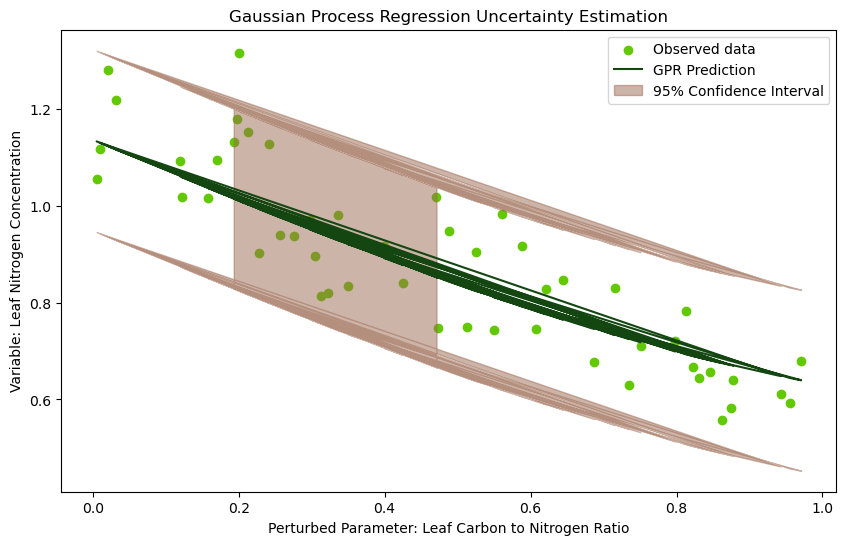

In [57]:
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
# ----        Visual Model Fit      ----
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
# Plot the results
plt.figure(figsize=(10, 6))
plt.scatter(x_test, y_test, color='#62c900ff', label='Observed data')
plt.plot(x_test, y_pred, color='#134611', label='GPR Prediction')
plt.fill_between(x_test.flatten(), y_pred - 1.96 * sigma, y_pred + 1.96 * sigma, alpha=0.5, color='#9d6b53', label = '95% Confidence Interval')
plt.xlabel('Perturbed Parameter: Leaf Carbon to Nitrogen Ratio')
plt.ylabel('Variable: Leaf Nitrogen Concentration')
plt.title('Gaussian Process Regression Uncertainty Estimation')
plt.legend()
plt.show()

### 2nd attempt

In [50]:
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
# ----      Set up Tune Grid         ----
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
# Define a grid of hyperparameters for the GPR model
tune_grid = {
    "kernel": [1.0 * RBF(length_scale=1.0)],
    # Add more kernel configurations as needed
}

In [51]:
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
# ----      Cross Validation        ----
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
# Perform grid search cross-validation to find the best hyperparameters
gpr = GaussianProcessRegressor(n_restarts_optimizer=20)

grid_search = GridSearchCV(gpr, tune_grid, cv=5, scoring='neg_mean_squared_error')

grid_search.fit(x_train, y_train)

GridSearchCV(cv=5, estimator=GaussianProcessRegressor(n_restarts_optimizer=20),
             param_grid={'kernel': [1**2 * RBF(length_scale=1)]},
             scoring='neg_mean_squared_error')

In [52]:
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
# ----      Collect Metrics         ----
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
# Get the best hyperparameters
best_kernel = grid_search.best_params_['kernel']

In [53]:
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
# ----         Fit Model            ----
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
# Generate predictions and confidence intervals for each variable using the trained model
y_pred, sigma = gpr_best.predict(x_test, return_std=True)

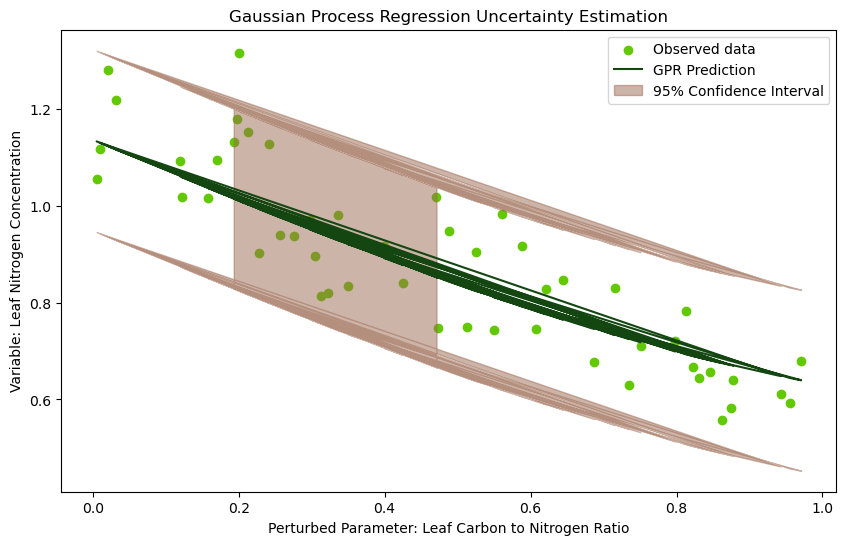

In [56]:
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
# ----        Visual Model Fit      ----
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
# Plot the results
plt.figure(figsize=(10, 6))
plt.scatter(x_test, y_test, color='#62c900ff', label='Observed data')
plt.plot(x_test, y_pred, color='#134611', label='GPR Prediction')
# applying z-score for 95% CI
plt.fill_between(x_test.flatten(), y_pred - 1.96 * sigma, y_pred + 1.96 * sigma, alpha=0.5, color='#9d6b53', label = '95% Confidence Interval')
plt.xlabel('Perturbed Parameter: Leaf Carbon to Nitrogen Ratio')
plt.ylabel('Variable: Leaf Nitrogen Concentration')
plt.title('Gaussian Process Regression Uncertainty Estimation')
plt.legend()
plt.show()

### 3rd attempt

In [8]:
# for simplicity's sake, we're going to use the preloaded data rn
leafcn = params['leafcn']

def plot_gpr(param, var):
    '''describe the relationship between the selected variable 
    and parameter(s) over the selected period of time. output a
    best fit line of regression.'''
    # Plotting
    plt.scatter(x=param, y=var, color = '#62c900ff', alpha = 0.8)
    # Set plot labels and title
    plt.xlabel(param)
    plt.ylabel(var)
    plt.title('2005-2010 Global Average')

    # Set boundaries

    # Gaussian Process Regression
    kernel = C(1.0, (1e-2, 1e2)) * RBF(1.0, (1e-2, 1e2))
    gp = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=20)
    x = param.reshape(-1, 1)
    y = var
    gp.fit(x, y)
    x_pred = np.linspace(0, 1, 100).reshape(-1, 1)
    y_pred, sigma = gp.predict(x_pred, return_std=True)
    plt.plot(x_pred, y_pred, '#134611', label='Gaussian Process Regression')
    plt.fill_between(x_pred.flatten(), y_pred - sigma, y_pred + sigma, alpha=0.2, color='#9d6b53')

    # Show legend with confidence interval
    plt.legend(loc='upper right',  bbox_to_anchor=(1, 1), labels=['Data', 'Gaussian Process Regression', '95% Confidence Interval'])


    # Show the plot
    plt.show()

AttributeError: 'DataArray' object has no attribute 'reshape'

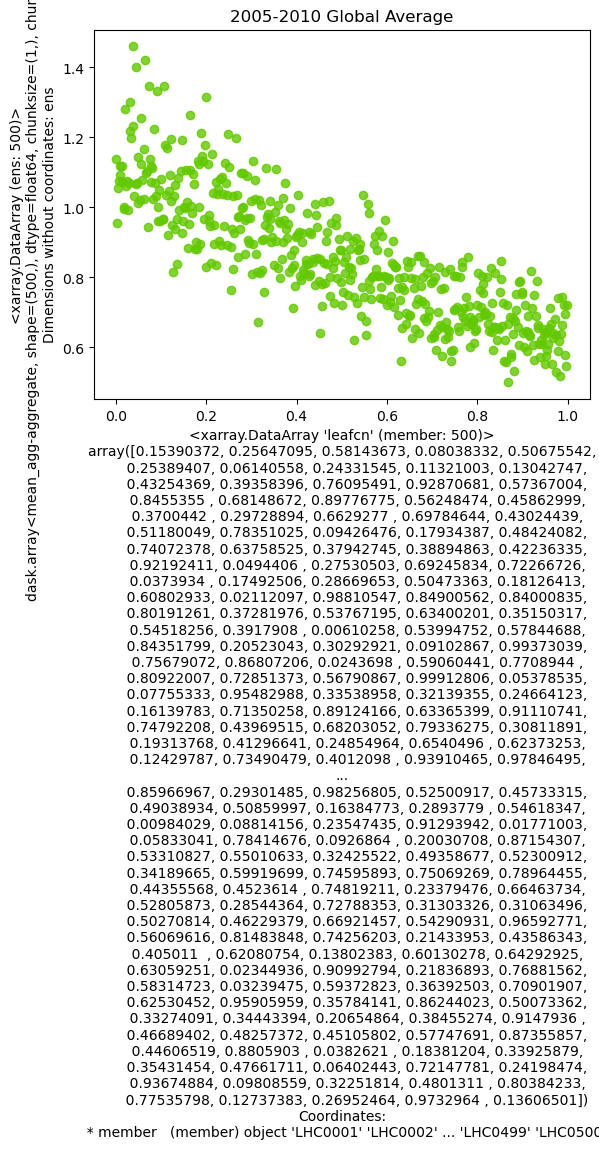

In [9]:
plot_gpr(leafcn, lnc)

Task exception was never retrieved
future: <Task finished name='Task-823269' coro=<Client._gather.<locals>.wait() done, defined at /glade/u/home/singersoll/.conda/envs/meds-py/lib/python3.11/site-packages/distributed/client.py:2208> exception=AllExit()>
Traceback (most recent call last):
  File "/glade/u/home/singersoll/.conda/envs/meds-py/lib/python3.11/site-packages/distributed/client.py", line 2217, in wait
    raise AllExit()
distributed.client.AllExit
Task exception was never retrieved
future: <Task finished name='Task-823132' coro=<Client._gather.<locals>.wait() done, defined at /glade/u/home/singersoll/.conda/envs/meds-py/lib/python3.11/site-packages/distributed/client.py:2208> exception=AllExit()>
Traceback (most recent call last):
  File "/glade/u/home/singersoll/.conda/envs/meds-py/lib/python3.11/site-packages/distributed/client.py", line 2217, in wait
    raise AllExit()
distributed.client.AllExit
Task exception was never retrieved
future: <Task finished name='Task-823609' c

Unexpected exception formatting exception. Falling back to standard exception


Task exception was never retrieved
future: <Task finished name='Task-823515' coro=<Client._gather.<locals>.wait() done, defined at /glade/u/home/singersoll/.conda/envs/meds-py/lib/python3.11/site-packages/distributed/client.py:2208> exception=AllExit()>
Traceback (most recent call last):
  File "/glade/u/home/singersoll/.conda/envs/meds-py/lib/python3.11/site-packages/distributed/client.py", line 2217, in wait
    raise AllExit()
distributed.client.AllExit
Task exception was never retrieved
future: <Task finished name='Task-823612' coro=<Client._gather.<locals>.wait() done, defined at /glade/u/home/singersoll/.conda/envs/meds-py/lib/python3.11/site-packages/distributed/client.py:2208> exception=AllExit()>
Traceback (most recent call last):
  File "/glade/u/home/singersoll/.conda/envs/meds-py/lib/python3.11/site-packages/distributed/client.py", line 2217, in wait
    raise AllExit()
distributed.client.AllExit
Task exception was never retrieved
future: <Task finished name='Task-823618' c

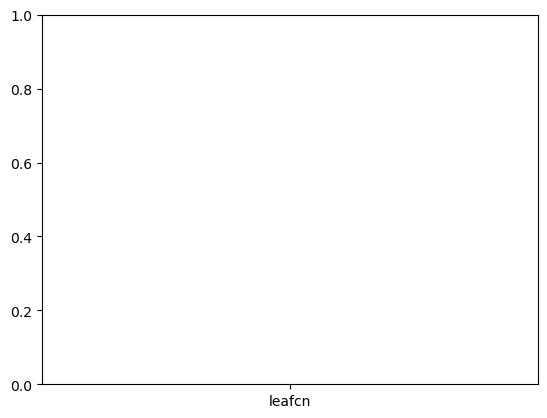

Task exception was never retrieved
future: <Task finished name='Task-823577' coro=<Client._gather.<locals>.wait() done, defined at /glade/u/home/singersoll/.conda/envs/meds-py/lib/python3.11/site-packages/distributed/client.py:2208> exception=AllExit()>
Traceback (most recent call last):
  File "/glade/u/home/singersoll/.conda/envs/meds-py/lib/python3.11/site-packages/distributed/client.py", line 2217, in wait
    raise AllExit()
distributed.client.AllExit
Task exception was never retrieved
future: <Task finished name='Task-823627' coro=<Client._gather.<locals>.wait() done, defined at /glade/u/home/singersoll/.conda/envs/meds-py/lib/python3.11/site-packages/distributed/client.py:2208> exception=AllExit()>
Traceback (most recent call last):
  File "/glade/u/home/singersoll/.conda/envs/meds-py/lib/python3.11/site-packages/distributed/client.py", line 2217, in wait
    raise AllExit()
distributed.client.AllExit
Task exception was never retrieved
future: <Task finished name='Task-823590' c

In [95]:
# Example usage:
plot_gpr('leafcn', lnc)